# Logistic Regression

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from numpy.linalg import inv
import matplotlib.pyplot as plt
from math import floor, log
import os

### read and process dataset

In [2]:
train_data = pd.read_csv("../assignment_2/dataset/train.csv")
test_data = pd.read_csv("../assignment_2/dataset/test.csv")

In [3]:
print("train_data.shape : ", train_data.shape)
train_data.head()

train_data.shape :  (32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
print("test_data.shape : ", test_data.shape)
test_data.head()

test_data.shape :  (16281, 14)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States


In [5]:
def preprocess_data_x(raw_data):
    data = raw_data.drop(["sex", "income"], axis=1) if "income" in raw_data.columns else raw_data.drop(["sex"], axis=1)
    
    # split the object column and num column
    list_object_column = [col for col in data.columns if data[col].dtypes == "object"]
    list_num_column = [d for d in list(data) if d not in list_object_column]
    
    # get data by column name
    object_data, num_data = data[list_object_column], data[list_num_column]
    
    # add a column(sex) in num_data, male=0, female=1
    num_data.insert(0, "sex", (raw_data["sex"] == " Female").astype(np.int))
    
    # for example, column(country) have three attributes : A ,B, C ，and then
    # there are three columns: country A, country B, country C to do onehot
    object_data = pd.get_dummies(object_data)
    
    data = pd.concat([num_data, object_data], axis=1)
    data_x = data.astype("int64")
    data_x = (data_x - data_x.mean()) / (data_x.std() + 1e-8)
    
    return data_x

def preprocess_data_y(raw_data):
    data_y = raw_data["income"]
    data_y = pd.DataFrame((data_y == " >50K").astype("int64"), columns=["income"])
    return data_y

### Prepare Utils function

In [6]:
def sigmoid(z):
    res = 1 / (1.0 + np.exp(-z))
    return np.clip(res, 1e-8, (1-(1e-8)))

def shuffle(X, Y):
    randomize = np.arange(X.shape[0])
    np.random.shuffle(randomize)
    return X[randomize], Y[randomize]

def split_dataset(data_x, data_y, percentage):
    
    valid_size = int(data_x.shape[0] * percentage)
    data_x, data_y = shuffle(data_x, data_y)
    
    x_train, x_valid = data_x[valid_size:], data_x[:valid_size]
    y_train, y_valid = data_y[valid_size:], data_y[:valid_size]
    
    return x_train, y_train, x_valid, y_valid

### Split Data

In [7]:
x_train = preprocess_data_x(train_data).drop(["native_country_ Holand-Netherlands"], axis=1).values
x_test = preprocess_data_x(test_data).values
y_train = preprocess_data_y(train_data).values

In [8]:
x_train = np.concatenate((np.ones((x_train.shape[0], 1)), x_train), axis=1)
x_test = np.concatenate((np.ones((x_test.shape[0], 1)), x_test), axis=1)

X_train, Y_train, X_valid, Y_valid = split_dataset(x_train, y_train, 0.2)

### Define hyperparameters

In [9]:
## hyperparameters

learning_rate = 1e-4
batch_size = 64
epochs = 15

### Train

In [10]:
def train(X_train, Y_train):
    
    weight = np.random.randn(X_train.shape[1])
    losses = []
    
    for epoch in range(epochs):
        loss_tmp = 0
        
        X_train, Y_train = shuffle(X_train, Y_train)
        
        for i in range(int(len(X_train) / batch_size)):
            x_sub = X_train[i * batch_size : (i + 1) * batch_size]
            y_sub = Y_train[i * batch_size : (i + 1) * batch_size]
            
            cur_grad = np.zeros(len(x_sub[0]))
            
            output = sigmoid(np.dot(x_sub, weight))
            
            cross_entropy = - (np.dot(np.squeeze(y_sub.T), np.log(output)) \
                                  + np.dot((1.0-np.squeeze(y_sub.T) + 1e-5), \
                                           np.log(1.0-y_sub + 1e-5))) / len(y_sub)
            loss_tmp += - cross_entropy
            
            grad = np.sum(x_sub * cross_entropy, axis=0)
#             grad = np.sum(-1 * x_sub * (np.squeeze(y_sub) - output).reshape((batch_size, 1)), axis=0)
            
            weight -= learning_rate * grad
            
        losses.append(loss_tmp)
    
    return losses, weight

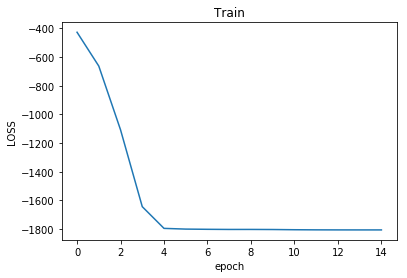

In [11]:
# train
losses, w_train = train(X_train, Y_train)

plt.plot(losses)
plt.title("Train")
plt.xlabel("epoch")
plt.ylabel("LOSS")
plt.show()

In [12]:
w_train.shape

(107,)

### Valid

In [13]:
def valid(X_valid, Y_valid, weight):
    output = sigmoid(np.dot(weight, X_valid.T))
    Y_test = np.around(output)
    result = np.squeeze(Y_valid) == Y_test
    
    return float(result.sum()) / result.shape[0]

In [14]:
result = valid(X_valid, Y_valid, w_train)
print('Valid accuracy = {}'.format(result))

Valid accuracy = 0.7595208845208845


### Ref
[https://github.com/maplezzz/NTU_ML2017_Hung-yi-Lee_HW/blob/master/HW2/lr.py](https://github.com/maplezzz/NTU_ML2017_Hung-yi-Lee_HW/blob/master/HW2/lr.py)